___


___
# NLP (Natural Language Processing) with Python


In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [2]:
import nltk

## Get the Data

We'll be using a dataset from the [Datasets for movie reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)! This dataset is already located in the folder for this section.

In [3]:
import pandas as pd

In [17]:
messages = pd.read_csv('train.tsv', delimiter='\t')
messages.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [21]:
messages.drop(columns='SentenceId', inplace=True)

In [31]:
messages.head(5)

,message,label
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [27]:
messages.rename(columns={'Phrase':'message',
                          'Sentiment':'label'}, 
                 inplace=True)

In [30]:
messages.columns

Index(['message', 'label'], dtype='object')

## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [32]:
messages.describe()

,label
count,156060.000000
mean,2.063578
std,0.893832
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate pos and neg!

In [33]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        7072   7072  there 's not an original character , siuation ...    1
1       27273  27273               a glorified episode of `` 7th Heaven    1
2       79582  79582          that 's been told by countless filmmakers    1
3       32927  32927  It 's light on the chills and heavy on the atm...    1
4        9206   9206  whose achievements -- and complexities -- reac...    1

In [34]:
messages['length'] = messages['message'].apply(len)
messages.head()

,message,label,length
0,A series of escapades demonstrating the adage ...,1,188
1,A series of escapades demonstrating the adage ...,2,77
2,A series,2,8
3,A,2,1
4,series,2,6


### Data Visualization
Let's visualize this! Let's do the imports:

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

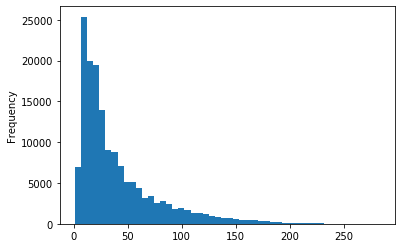

In [36]:
messages['length'].plot(bins=50, kind='hist')

In [37]:
messages.length.describe()

count    156060.000000
mean         40.217224
std          38.154130
min           1.000000
25%          14.000000
50%          26.000000
75%          53.000000
max         283.000000
Name: length, dtype: float64

Woah! 13704 characters, let's use masking to find this message:

In [38]:
messages[messages['length'] == 283]['message'].iloc[0]

"... spiced with humor -LRB- ' I speak fluent flatula , ' advises Denlopp after a rather , er , bubbly exchange with an alien deckhand -RRB- and witty updatings -LRB- Silver 's parrot has been replaced with Morph , a cute alien creature who mimics everyone and everything around -RRB-"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014BD072CEF0>,
      dtype=object)

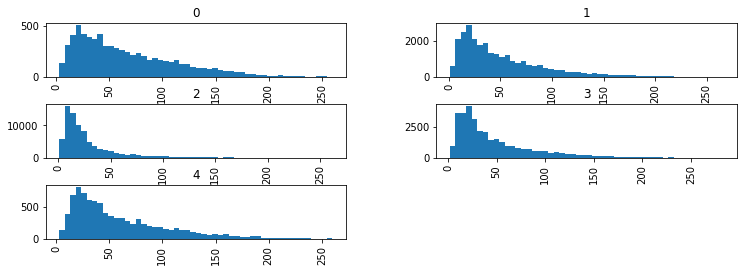

In [39]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

## Text Pre-processing

In [40]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [41]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [42]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [43]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [44]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [59]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Remove the html parser or tag
    #nopunc = BeautifulSoup(mess, "html.parser").get_text()
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    pattern=r'[^a-zA-z0-9\s]'
    nopunc=re.sub(pattern,'',nopunc)
    
    #Removing the square brackets
    nopunc = re.sub('\[[^]]*\]', '', nopunc)
    
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [46]:
messages.head()

,message,label,length
0,A series of escapades demonstrating the adage ...,1,188
1,A series of escapades demonstrating the adage ...,2,77
2,A series,2,8
3,A,2,1
4,series,2,6


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:


In [47]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [series, escapades, demonstrating, adage, good...
1    [series, escapades, demonstrating, adage, good...
2                                             [series]
3                                                   []
4                                             [series]
Name: message, dtype: object

In [48]:
# Show original dataframe
messages.head()

,message,label,length
0,A series of escapades demonstrating the adage ...,1,188
1,A series of escapades demonstrating the adage ...,2,77
2,A series,2,8
3,A,2,1
4,series,2,6


## Vectorization

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [58]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

255985


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [59]:
message4 = messages['message'][3]
print(message4)

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


Now let's see its vector representation:

In [60]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 94)	1
  (0, 10560)	1
  (0, 11827)	1
  (0, 25694)	1
  (0, 45831)	4
  (0, 66400)	1
  (0, 71415)	1
  (0, 103503)	1
  (0, 107988)	1
  (0, 112307)	1
  (0, 120329)	2
  (0, 128950)	1
  (0, 130210)	1
  (0, 131063)	1
  (0, 133613)	1
  (0, 135100)	3
  (0, 142457)	1
  (0, 144165)	1
  (0, 146122)	1
  (0, 146252)	2
  (0, 147744)	1
  (0, 154123)	1
  (0, 164118)	1
  (0, 166911)	1
  (0, 171367)	1
  :	:
  (0, 184839)	3
  (0, 186798)	1
  (0, 193599)	1
  (0, 196824)	2
  (0, 200716)	1
  (0, 208204)	1
  (0, 213944)	1
  (0, 217495)	1
  (0, 220882)	1
  (0, 221902)	1
  (0, 223429)	1
  (0, 224221)	1
  (0, 226754)	1
  (0, 230842)	1
  (0, 236141)	2
  (0, 236636)	1
  (0, 237474)	2
  (0, 238266)	1
  (0, 239954)	1
  (0, 249303)	1
  (0, 249335)	1
  (0, 250322)	1
  (0, 255541)	1
  (0, 255866)	1
  (0, 255869)	1
(1, 255985)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [61]:
print(bow_transformer.get_feature_names()[94])
print(bow_transformer.get_feature_names()[45831])

10
Jake


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire reviews corpus is a large, sparse matrix:

In [62]:
messages_bow = bow_transformer.transform(messages['message'])

In [63]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (50000, 255985)
Amount of Non-Zero occurences:  5044600


In [65]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### TF-IDF

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 255869)	0.20343709565307747
  (0, 255866)	0.1056718277336957
  (0, 255541)	0.06997547984835885
  (0, 250322)	0.044712404685969584
  (0, 249335)	0.06479141818546483
  (0, 249303)	0.10084136454306664
  (0, 239954)	0.07466160119556126
  (0, 238266)	0.15110528179751925
  (0, 237474)	0.17298473500116945
  (0, 236636)	0.09321745611200966
  (0, 236141)	0.13849727240191861
  (0, 230842)	0.09291162731234284
  (0, 226754)	0.20343709565307747
  (0, 224221)	0.10731027555858091
  (0, 223429)	0.13741591408219006
  (0, 221902)	0.08272932579439594
  (0, 220882)	0.08188045737655504
  (0, 217495)	0.039590739770570725
  (0, 213944)	0.12056410286702753
  (0, 208204)	0.0545084161004045
  (0, 200716)	0.07169094139974093
  (0, 196824)	0.17326025560556302
  (0, 193599)	0.10528417151030094
  (0, 186798)	0.05979397956713852
  (0, 184839)	0.08338804296858891
  :	:
  (0, 171367)	0.07896239976843385
  (0, 166911)	0.07071954269076997
  (0, 164118)	0.1119461075918524
  (0, 154123)	0.05545532474394398
  (0, 147

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [71]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

6.643648551636456
7.245087305706903


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [72]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(50000, 255985)


## Training a model

With messages represented as vectors, we can finally train our pos/neg classifier. Now we use  the Naive Bayes classifier algorithm.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [73]:
from sklearn.naive_bayes import MultinomialNB
review_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [74]:
print('predicted:', review_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: negative
expected: negative


Fantastic! We've developed a model that can attempt to predict pos vs neg classification!

## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [75]:
all_predictions = review_detect_model.predict(messages_tfidf)
print(all_predictions)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [76]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

    negative       0.92      0.93      0.92     25000
    positive       0.93      0.91      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000




## Train Test Split

In [56]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.01)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

154499 1561 156060


The test size is 1% of the entire dataset.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [85]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [86]:
pipeline.fit(messages['message'],messages['label'])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [88]:
predictions = pipeline.predict(msg_test)

In [49]:
msg_new = [line.rstrip() for line in open('checkfolder/checkMsg')]

In [141]:
predictions = pipeline.predict(msg_new)

In [82]:
predictions[:20]

array([2, 1, 2, 1, 3, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

In [65]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.14      0.71      0.23        14
           1       0.31      0.52      0.39       163
           2       0.88      0.64      0.74      1122
           3       0.42      0.47      0.44       256
           4       0.04      0.67      0.07         6

    accuracy                           0.60      1561
   macro avg       0.36      0.60      0.37      1561
weighted avg       0.73      0.60      0.64      1561



In [90]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.17      0.92      0.28        13
           1       0.31      0.63      0.42       134
           2       0.93      0.64      0.76      1175
           3       0.41      0.51      0.46       232
           4       0.05      0.86      0.10         7

    accuracy                           0.63      1561
   macro avg       0.37      0.71      0.40      1561
weighted avg       0.79      0.63      0.68      1561



In [123]:
pipeline.predict(['this is awesome movie'])

array([4], dtype=int64)

In [104]:
mse = ((predictions - label_test) ** 2).mean()

In [107]:
from math import sqrt
sqrt(mse)

0.7387854707646465

## Saving Model by Joblib

In [135]:
# import joblib don't worry about warning this is bug of sklearn

from sklearn.externals import joblib

C:\Users\tamim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [136]:
joblib.dump(pipeline, 'modelreviews.joblib')

['modelreviews.joblib']

In [137]:
# load that model file
# Later Run from this

model = joblib.load('modelreviews.joblib')

In [139]:
# now predict using this loaded model
predictions = model.predict(['this is worst movie'])

In [140]:
predictions

array([1], dtype=int64)

In [64]:
if __name__ == "__main__":
    main()

NameError: name 'main' is not defined

## Save Model by Pickle

In [124]:
import pickle

In [125]:
filename = 'finalized_model.sav'

In [127]:
# save the model to disk

pickle.dump(pipeline, open(filename, 'wb'))

In [3]:
# before load run this function
def text_process(mess):
    nopunc = BeautifulSoup(mess, "html.parser").get_text()
    nopunc = [char for char in nopunc if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    pattern=r'[^a-zA-z0-9\s]'
    nopunc=re.sub(pattern,'',nopunc)
    nopunc = re.sub('\[[^]]*\]', '', nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [128]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


In [66]:
# now predict using this loaded model
loaded_model.predict(msg_new)

array(['positive', 'negative', 'positive', 'negative'], dtype='<U8')

## String Prediction

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [134]:
review = "this is extreme movie"
loaded_model.predict([review])

array([2], dtype=int64)

# Happy Ending!